### Import required packages

In [3]:
import numpy as np
import pandas as pd
import os
from os import path
from PIL import Image
import wordcloud
import nltk
import re
import ast
import time
import datetime
import json
from wordcloud import WordCloud
from collections import Counter 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from bs4 import BeautifulSoup
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karthik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karthik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Open the corresponding dataset based on the file encoding type and extension

In [4]:
#Open corresponding file
filename = "bb"
file_format = filename+'.csv'
filename = file_format
encoding = ['utf8','latin1','iso-8859-1','cp1252']
flag = False
encoding_list = len(encoding)
if file_format.endswith('.html'):
    dfs = pd.read_html(file_format)
    df  = pd.concat(dfs)
    df.to_csv(filename+".csv",index=False)
if file_format.endswith('.json'):
    df = pd.read_json(filename)
if 'parsed.csv' in filename:
    df = pd.read_csv(file_format, index_col=0 )
    flag = True
if flag != True:
#Try all the possible encoding schemes to see which one applies to the dataset
    for encoding_type in range(0,encoding_list-1):
        try:
            if file_format.endswith('.csv'):
                df = pd.read_csv(file_format, index_col=0 , encoding = encoding[encoding_type])
                break
        except Exception:
            pass

### Selecting column which is to be parsed (Posts)

In [5]:
def chooseColumn(df):
    IndexToBePlotted = []
    print("The column name and the index are listed below:\n")
    for index,column in enumerate(df.columns):
        print(index,column)
    print("\n")
    for i in range(0, 1):
        Number = int(input("\nEnter the column index \n"))    
        IndexToBePlotted.append(Number) 
    columns_to_plot = [df.columns[i] for i in IndexToBePlotted]
    return columns_to_plot

In [6]:
columns_to_plot = chooseColumn(df)

The column name and the index are listed below:

0 timestamp
1 data
2 title
3 attachments
4 tags



Enter the column index 
1


### Removing Links

In [7]:
df[columns_to_plot[0]] = df[columns_to_plot[0]].str.replace('http\S+|www.\S+','', case=False)

### Removing special characters

In [8]:
df[columns_to_plot[0]].replace(regex=True, inplace=True, to_replace=r'[^a-zA-Z0-9]+', value=r' ')

### Display the dataset

In [9]:
df

,timestamp,data,title,attachments,tags
0,2020-01-13 18:34:00,post Lokwinske Een dagje te laat maar dat mag...,Eelco Herder wrote on Chris Kalsbeek's timeline.,NaN,NaN
1,2020-01-13 14:58:44,post 1009646612 2048 Maria Bielikova has been...,Eelco Herder,[{'data': [{'external_context': {'url': 'https...,NaN
2,2020-01-10 17:26:48,post Thanks to Claus Atzenbeck for welcoming ...,NaN,[{'data': [{'media': {'uri': 'photos_and_video...,NaN
3,2020-01-07 22:23:35,post Happy Birthday Ricardo,Eelco Herder wrote on Rick Kawase's timeline.,NaN,NaN
4,2020-01-04 17:44:02,post Getekend Mede namens 142505575958207 274...,Eelco Herder,[],NaN
...,...,...,...,...,...
1356,2008-05-07 11:49:34,post Self acclaimed Web guru Jakob Nielsen wr...,Eelco Herder,[{'data': [{'external_context': {'url': 'http:...,NaN
1357,2008-05-07 11:32:38,post Dutch vegetarian Website I am an active ...,Eelco Herder,[{'data': [{'external_context': {'url': 'http:...,NaN
1358,2008-05-07 11:27:51,post I am the local chair of the AH2008 confe...,Eelco Herder,[{'data': [{'external_context': {'url': 'http:...,NaN
1359,2008-05-06 12:06:17,post Does anyone know good systems for Web an...,NaN,NaN,NaN


In [10]:
#Available languages for stopwords
stopwords_language = ['english','german','dutch','hungarian','swedish','kazakh','norwegian','finnish','arabic','indonesian','portuguese','turkish','azerbaijani','slovene','spanish','danish',
 'nepali','romanian','greek','tajik','russian','french','italian']

### Method to plot a wordcloud 

In [11]:
def plotwordcloud(wordlist1,wordlist2):
    #Takes the words sorted based on rank difference and computes the corresponding wordclouds
    wordlist1 = wordlist1
    wordlist2 = wordlist2
    text = []
    plt.title("Wordcloud of group 1 followed by group 2\n")
    for val in range(0,2):
        if val == 0:
            text = wordlist1
        elif val == 1:
            text = wordlist2
        else:
            pass
        listToStr = ' '.join([str(elem) for elem in text]) 
        wordcloud = WordCloud().generate(listToStr)
        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

### Method that performs stopword removal and tokenizing

In [12]:
def returnList(wordlist,grouptype,languageindex):
    try:
        #Sets the language for stopwords and stemming operation
        grouptype = grouptype
        flag = True
        word_dictionary = []
        word_dictionary = wordlist
        joinedWords = []
        filtered_sentence = [] 
        languageindex = languageindex
        language = []
        if languageindex != 0:
            for index in range (0, len(languageindex)):
                language.append(stopwords_language[int(languageindex[index])])
            #Language for stopwords can be chosen from the stopwords_language list listed above
            stop_words = set(stopwords.words(language[0]))
            for index in range(1, len(language)):
                stop_words.update(set(stopwords.words(language[index])) ) 
        else:
            stop_words = set(stopwords.words('english'))
        #Updates the stopwords with characters from a-z
        stop_words.update([chr(x) for x in range(ord('a'), ord('z')+1)]) 
        new_stopwords = ['post','update','timestamp','https','co']
        stop_words = stop_words.union(new_stopwords)
        for i in range(0,len(word_dictionary)):
            #Removes all the http links in the list.
            link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
            links         = re.findall(link_regex, word_dictionary[i])
            for link in links:
                word_dictionary[i] = word_dictionary[i].replace(link[0], ', ') 
        if grouptype == 3 or grouptype == 4:
            # Removes all the special characters in the list
            removeSpecialChar = [re.sub('[^a-zA-Z@#]+',' ', elem) for elem in word_dictionary]
            #convert to lower case for uniformity
            toLower = [x.lower() for x in removeSpecialChar]
            #invoke tweet tokenizer for dealing with tweets
            tknr = TweetTokenizer()
            word_tokens = [tknr.tokenize(x) for x in toLower]
        else:
            removeSpecialChar = [re.sub('[^a-zA-Z]+',' ', elem) for elem in word_dictionary]
            toLower = [x.lower() for x in removeSpecialChar]
            word_tokens = [word_tokenize(x) for x in toLower]
        #Loop through all the values to match the stopwords and discard them.
        for val in word_tokens: 
            for word in val:
            # update the stopword list with the alphabets from a-z
                if word not in stop_words: 
                    filtered_sentence.append(word)
        return filtered_sentence
    except ValueError as e:
        print("Value error {} occured".format(e))

### Choosing language for computing Rank difference

In [13]:
def selectLanguage():
    try:
        language_index = []
        languages = []
        count = 0
        language_preferred = []
        language = input("Do you want to compute the rank difference in english? Press Yes or No\n")
        language.lower()
        if language == 'yes' or language == 'y':
            language_index = 0
            # Passes the user selected language to perform the stemming and stopword operations. 
        elif language == 'no' or language == 'n':
            print("The index and the available languages are listed below:\n")
            for index,language in enumerate(stopwords_language):
                print(index,language)
            print("\n")
            while True:
                choice = input("Enter the column index of the preferred languages or Press Enter to exit\n")
                if choice.isnumeric():
                    language_index.append(choice)
                    count += 1
                elif choice == '':
                    if count > 0:
                        for index in range (0, len(language_index)):
                            languages.append(stopwords_language[int(language_index[index])])
                        print("Done selecting Languages:", end =" ")
                        for val in languages:
                            print(val, end =" ")
                    else:
                        print("Exiting the function")
                    break 
        else:
            print("Please enter a valid choice")
        return language_index
    except ValueError as e:
            print("Value error {} occured".format(e))

### Method to compute the rank difference

In [14]:
def computeRankDifference(lista, listb ,limit, listOnly=False):
        listA = lista
        listB = listb
        limit = limit
        listOnly = listOnly
        sizeA = len(listA)
        sizeB = len(listB)
        wordlist1 = {}
        wordlist2 = {}
        # list of all terms
        dictionary = list(set(listA) | set(listB))
        differences = list()
        for term in dictionary:
            try:
                rankA = listA.index(term) + 1
            except ValueError:
                rankA = sizeA # sizeA + 1 instead?
            try:
                rankB = listB.index(term)
            except ValueError:
                rankB = sizeB
            rankDiff = 1.0*rankA/sizeA - 1.0*rankB/sizeB # in [-1,1]
            differences.append((term, rankDiff))
        if not listOnly:
            print("\nDescriptive terms for Group1 and Group2 are listed below:")
            wordlist1.update(sorted(differences, key=lambda i: i[1])[0:limit])
            wordlist2.update(sorted(differences, key=lambda i: i[1] ,reverse=True)[0:limit])
            #The wordlists are stored as a dictionary key being the words and values being the rank values so we pick only the keys
            pd1 = pd.DataFrame(wordlist1.keys() , columns = ["Group1"] )
            pd2 = pd.DataFrame(wordlist2.keys() , columns = ["Group2"] )
            frames = [pd1,pd2]
            # Create a new concatenated dataframe for both the groups containing the keys 
            df1 = pd.concat(frames, axis=1)
            keys1, values = zip(*wordlist1.items())
            keys2, values = zip(*wordlist2.items()) 
            fileList1 = list(keys1)
            fileList2 = list(keys2)
            df4 = pd.DataFrame(fileList1, columns=["Group1 word list"])
            df5 = pd.DataFrame(fileList2, columns=["Group2 word list"])
            df4.to_csv("RankDifference_Group1.txt", index=False)
            df5.to_csv("RankDifference_Group2.txt", index=False)
            print(df1)
            choice = input("Do you want to compute the wordclouds of the columns? Type Yes or no\n")
            choice.lower()
            if choice == 'yes' or choice == 'y':
                #invoke wordcloud method
                plotwordcloud(list(keys1),list(keys2))
            else:
                pass
        else:
            for item in sorted(differences, key=lambda i: i[1])[0:limit]:
                print(item[0])

### Method that sorts words based on frequency of occurence

In [15]:
#Takes a list and returns a descending sorted dict of words and their counts
def countWords(a_list):
    words = {}
    for i in range(len(a_list)):
        item = a_list[i]
        count = a_list.count(item)
        words[item] = count
    return sorted(words.items(), key = lambda item: item[1], reverse=True)

### Method to group the set of words based on user selected choice and criteria

In [16]:
def rankgroups(groupType,ColumnIndexToBePlotted,languageindex):
    try:
        list1 = []
        list2 = []
        languageindex = languageindex
        listOnly=False
        notextFound=False
        groupType = groupType
        ColumnIndexToBePlotted = ColumnIndexToBePlotted
        columnToGroup = ""
        columns_to_plot = df.loc[:, df.dtypes == object].columns[ColumnIndexToBePlotted]
        dateColumns = df.columns[ColumnIndexToBePlotted]
        if groupType == 1 or groupType == 3:
            if groupType == 1:
                text = str(input("Enter the text based on which you want to filter the group\n"))
            else:
                text = str(input("Enter the hashtag based on which you want to filter the group\n"))
            #Check if the entered text/hastag is present in the column.
            if df[columns_to_plot].str.contains(text,case=False).any():
                #Place the rows with matching text into a seperate dataframe 
                df1 = df[df[columns_to_plot].str.contains(text , case=False)]
                #Place the rows with the rest of text into a seperate dataframe
                df2 = df[~df[columns_to_plot].str.contains(text , case=False )]
                list1 = df1[columns_to_plot].to_list()
                list2 = df2[columns_to_plot].to_list()
            else:
                print("The entered text cannot be found.")
                notextFound = True
        elif groupType == 2 or groupType == 4:
            if groupType == 2:
                text1 = str(input("Enter the word based on which you want to filter the first group\n"))
                text2 = str(input("Enter the word based on which you want to filter the second group\n"))
            else:
                text1 = str(input("Enter the Hashtag/username based on which you want to filter the first group\n"))
                text2 = str(input("Enter the Hashtag/username based on which you want to filter the second group\n"))
            if df[columns_to_plot].str.contains(text1,case=False).any() or df[columns_to_plot].str.contains(text2,case=False).any():
                df1 = df[df[columns_to_plot].str.contains(text1 , case=False)]
                df2 = df[df[columns_to_plot].str.contains(text2 , case=False)]
                list1 = df1[columns_to_plot].to_list()
                list2 = df2[columns_to_plot].to_list()
            else:
                print("The entered Hashtag cannot be found")
                notextFound = True
        elif groupType == 5 or groupType == 6:
            df0 = df
            df0[dateColumns] = pd.to_datetime(df0[dateColumns],errors ='coerce' )
            print(dateColumns)
            df0 = df0.sort_values(by=dateColumns,ascending=True)
            if groupType == 5:
                #Check if the entered date is present in the selected column.
                startdate = str(input("Enter the start date(YYYY-MM-DD) based on which you want to filter the group\n"))
                enddate = str(input("Enter the end date(YYYY-MM-DD) based on which you want to filter the group\n"))
                df3 = df0[(df0[dateColumns] > startdate) & (df0[dateColumns] < enddate)]
                if df3.empty:
                    print("The entered date cannot be found")
                    notextFound = True
                else:
                    for index,column in enumerate(df0.loc[:, df0.dtypes == object]):
                        print(index,column) 
                    for i in range(0, 1):
                        Number = int( input("Enter the column index for which you want to group based on entered date\n"))
                    if Number < len(df0.columns[df0.dtypes == object]):
                        ColumnIndexToBePlotted = Number
                        date_columns_to_plot = df3.loc[:, df3.dtypes == object].columns[ColumnIndexToBePlotted]
                        if groupType == 5:
                            text = str(input("Enter the text based on which you want to filter the group\n"))
                        if df3[date_columns_to_plot].str.contains(text,case=False).any():
                            df1 = df3[df3[date_columns_to_plot].str.contains(text , case=False)]
                            df2 = df3[~df3[date_columns_to_plot].str.contains(text , case=False )]
                            list1 = df1[date_columns_to_plot].to_list()
                            list2 = df2[date_columns_to_plot].to_list()
                        else:
                            print("The entered text cannot be found.")
                            notextFound = True
            else:
                startdate1 = str(input("Enter the start date(YYYY-MM-DD) based on which you want to filter the first group\n"))
                enddate1 = str(input("Enter the end date(YYYY-MM-DD) based on which you want to filter the first group\n"))
                startdate2 = str(input("Enter the start date(YYYY-MM-DD) based on which you want to filter the second group\n"))
                enddate2 = str(input("Enter the end date(YYYY-MM-DD) based on which you want to filter the second group\n"))
                df3 = df0[(df0[dateColumns] > startdate1) & (df0[dateColumns] < enddate1)]
                df4 = df0[(df0[dateColumns] > startdate2) & (df0[dateColumns] < enddate2)]
                if df3.empty:
                    print("The entered date cannot be found")
                    notextFound = True
                else:
                    for index,column in enumerate(df0.loc[:, df0.dtypes == object]):
                        print(index,column) 
                    for i in range(0, 1):
                        Number = int( input("Enter the column index for which you want to group based on entered date\n"))
                    if Number < len(df0.columns[df0.dtypes == object]):
                        dateColumnIndexToBePlotted = Number
                        date_columns_to_plot = df3.loc[:, df3.dtypes == object].columns[dateColumnIndexToBePlotted]
                        list1 = df3[date_columns_to_plot].to_list()
                        list2 = df4[date_columns_to_plot].to_list()
                    else:
                        print("Enter a valid index")
        if notextFound != True:
            choice = input("Do you want to apply stopwords and stemming operations?Press Yes or No \n")
            choice.lower()
            if choice == 'Yes' or choice == 'y':                
                #returns word list after stopword removal, stemming and tokenizing
                tokenized_group1 = returnList(list1,groupType,languageindex)
                tokenized_group2 = returnList(list2,groupType,languageindex)
                #Sort the word list based on the frequency of occurence starting from hightest to lowest
                freq_sortedList1 = countWords(tokenized_group1)
                freq_sortedList2 = countWords(tokenized_group2)
                wordList1 = [val[0] for val in freq_sortedList1] 
                wordList2 = [val[0] for val in freq_sortedList2] 
            elif choice == 'No' or choice == 'n':
                wordList1 = list1
                wordList2 = list2
            else:
                print("Enter a valid choice")
            choice = int(input("Enter the number of terms to be displayed in the rank difference output\n"))
            #Invoke the rank difference method
            computeRankDifference(wordList1,wordList2,choice,listOnly)
        else:
            pass
    except ValueError as e:
        print("Value error {} occured".format(e))

### Selecting the type of group for computing Rank difference

Do you want to compute the rank difference in english? Press Yes or No
n
The index and the available languages are listed below:

0 english
1 german
2 dutch
3 hungarian
4 swedish
5 kazakh
6 norwegian
7 finnish
8 arabic
9 indonesian
10 portuguese
11 turkish
12 azerbaijani
13 slovene
14 spanish
15 danish
16 nepali
17 romanian
18 greek
19 tajik
20 russian
21 french
22 italian


Enter the column index of the preferred languages or Press Enter to exit
0
Enter the column index of the preferred languages or Press Enter to exit
1
Enter the column index of the preferred languages or Press Enter to exit
2
Enter the column index of the preferred languages or Press Enter to exit

Done selecting Languages: english german dutch Choose the type of groups for which you want the rank difference :
                           
1:Group containing user specified words with all the other text                          
2:Groups of text sorted upon two different user specified words                          
3

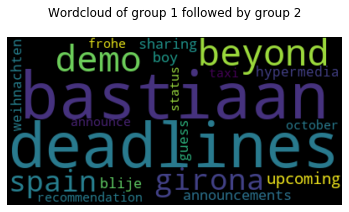

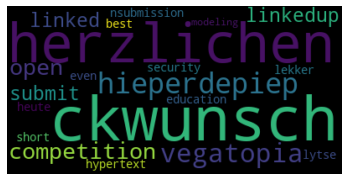

In [21]:
try:
    languageIndex = selectLanguage()
    groupType = int(input("Choose the type of groups for which you want the rank difference :\n \
                          \n1:Group containing user specified words with all the other text\
                          \n2:Groups of text sorted upon two different user specified words\
                          \n3:Tweets grouped on a specific hashtag/username from all other tweets \
                          \n4:Tweets grouped based on two different hashtags/twitter usernames \
                          \n5:Rank difference based on words sorted upon user specified start and end date\
                          \n6:Rank difference of a user specified column data based on two different time periods\n"))
    if groupType > 6 or groupType == 0:
        print("Enter a valid option")
    else:
        df.loc[:].replace(np.nan,'',regex = True, inplace=True)
        #convert the column names to lower case and remove spaces for uniformity
        if df.columns.dtype == object:
            df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        #Lists the categorical columns in a dataset to deal with words or tweets.
        if groupType < 5:
            for index,column in enumerate(df.loc[:, df.dtypes == object]):
                print(index,column)
            for i in range(0, 1):
                Number = int( input("Enter the column index you want to group\n"))
        #Lists all  columns in a dataset to deal with numerical columns such as dates.
        elif groupType == 5 or groupType == 6:
            for index,column in enumerate(df.columns):
                print(index,column)
            for i in range(0, 1):
                Number = int( input("Enter the date column index you want to group\n"))
        #Loops through the columns of type object
        if groupType <= 4:
            if Number < len(df.columns[df.dtypes == object]):
                ColumnIndexToBePlotted = Number
                rankgroups(groupType,ColumnIndexToBePlotted,languageIndex)
            else:
                print("Enter a valid index")
        else:
            if Number < len(df.columns):
                ColumnIndexToBePlotted = Number
                rankgroups(groupType,ColumnIndexToBePlotted,languageIndex)
            else:
                print("Enter a valid index")
except ValueError as e:
        print("Value error {} occured".format(e))